In [34]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA


import helpers
from src import dataset

In [2]:
excel_file = "20160921-analysisofestimatedarrivals.xlsx"
data = dataset.load_excel(excel_file)
data = dataset.load_all_regions(data)

In [3]:
df_italy = data["italy"] # Arrivals to Italy
df_greek_island = data["greek_island"] # Arrivals to Greek Island
df_mainland_greece = data["mainland_greece"] # Arrivals to Mainland greece
df_fyrom = data["fyrom"] # Arrivals to fYRoM
df_serbia = data["serbia"] # Arrivals to Serbia
df_croatia = data["croatia"] # Arrivals to Croatia
df_hungry = data["hungry"] # Arrivals to Hungry
df_slovenia = data["slovenia"] # Arrivals to Slovenia
df_austria = data["austria"] # Arrivals to Austria

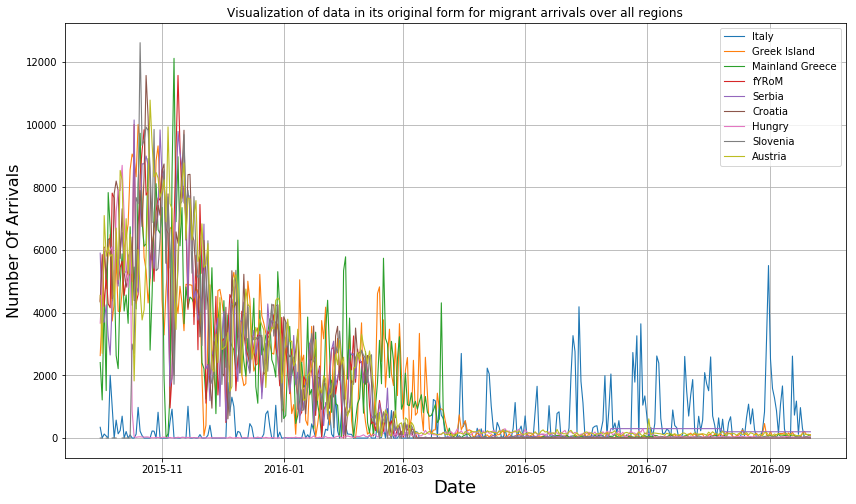

In [4]:
plt.figure(figsize=(14,8))
plt.plot(df_italy.index, df_italy.iloc[:, 0], label="Italy", linewidth=1.1)
plt.plot(df_greek_island.index, df_greek_island.iloc[:, 0], label="Greek Island", linewidth=1.1)
plt.plot(df_mainland_greece.index, df_mainland_greece.iloc[:, 0], label="Mainland Greece", linewidth=1.1)
plt.plot(df_fyrom.index, df_fyrom.iloc[:, 0], label="fYRoM", linewidth=1.1)
plt.plot(df_serbia.index, df_serbia.iloc[:, 0], label="Serbia", linewidth=1.1)
plt.plot(df_croatia.index, df_croatia.iloc[:, 0], label="Croatia", linewidth=1.1)
plt.plot(df_hungry.index, df_hungry.iloc[:, 0], label="Hungry", linewidth=1.1)
plt.plot(df_slovenia.index, df_slovenia.iloc[:, 0], label="Slovenia", linewidth=1.1)
plt.plot(df_austria.index, df_austria.iloc[:, 0], label="Austria", linewidth=1.1)
plt.legend(loc="best")
plt.title("Visualization of data in its original form for migrant arrivals over all regions")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number Of Arrivals', fontsize=16)
plt.grid(True)
plt.show()

In [115]:
df = df_austria # Seriies to test
column_name = df.columns[0]
print("Region %s will be used for the analysis" % column_name)

Region Arrivals to Austria will be used for the analysis


In [116]:
fill_method = "ffill"
df.fillna(0, inplace=True)
df[df.columns[0]] = df[column_name].replace(to_replace=0, method=fill_method) # Replace 0 in series
# df.loc["2015-12-31"]

In [117]:
# df.loc["2015-10-11"]
# df.values
# df.groupby(df.iloc[:, 0]).count()


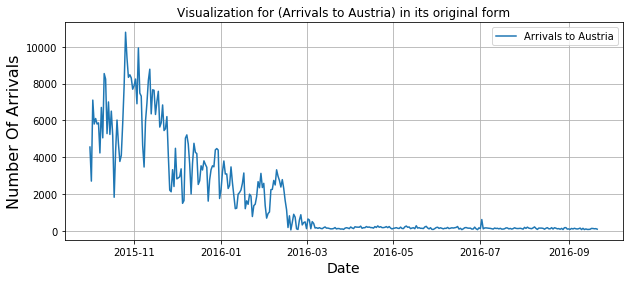

In [118]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number Of Arrivals', fontsize=16)
plt.grid()
plt.show()

In [119]:
df.describe()

,Arrivals to Austria
count,357.000000
mean,1733.781513
std,2429.884425
min,50.000000
25%,133.000000
50%,196.000000
75%,2764.000000
max,10784.000000


In [120]:
df_to_orig = copy.deepcopy(df)
df_to_orig[column_name] = df_to_orig[column_name].replace(to_replace=0, method=fill_method)
df_to_orig = df_to_orig.fillna(method=fill_method)

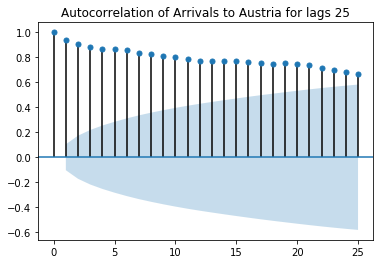

In [121]:
lags_used = 25
plot_acf(df_to_orig,lags=lags_used,title="Autocorrelation of %s for lags %s" % (column_name, lags_used))
plt.show()

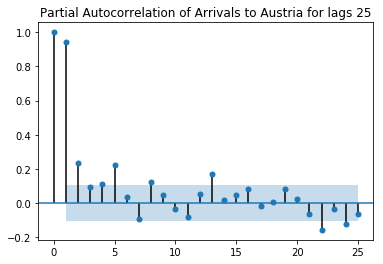

In [122]:
lags_used = 25
plot_pacf(df_to_orig,lags=lags_used,title="Partial Autocorrelation of %s for lags %s" % (column_name, lags_used))
plt.show()

In [123]:
#Stationarity test
def test_stationarity(timeseries, win_size=7):
    #Find rolling statistics
    rolmean = timeseries.rolling(window=win_size).mean()
    rolstd = timeseries.rolling(window=win_size).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10,8))
    orig = plt.plot(timeseries, linewidth=1.2,label='Original')
    mean = plt.plot(rolmean, linewidth=1.2, label='Rolling Mean')
    std = plt.plot(rolstd, linewidth=1.2, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for Stationarity (Window size %s days)' % win_size)
    plt.grid()
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[timeseries.columns[0]], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

def show_seasonality(series, freq=7):
    plt.figure(figsize=(10,4))
    decomposition = seasonal_decompose(series, freq=freq, model="additive")
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    return(trend, seasonal, residual)

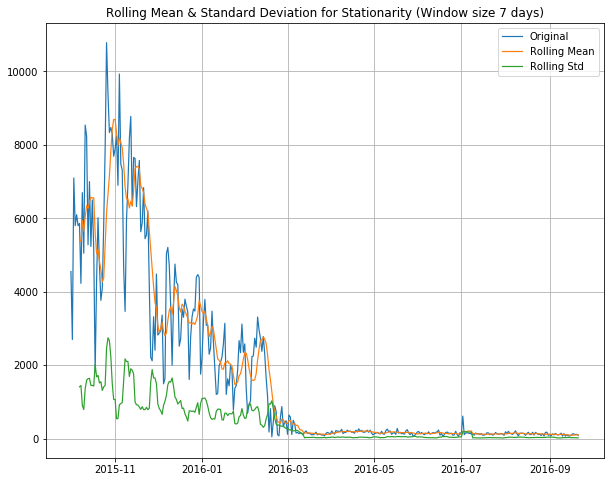

Results of Dickey-Fuller Test:
Test Statistic                  -1.977712
p-value                          0.296430
#Lags Used                      13.000000
Number of Observations Used    343.000000
Critical Value (10%)            -2.571279
Critical Value (1%)             -3.449560
Critical Value (5%)             -2.870004
dtype: float64


In [124]:
test_stationarity(df_to_orig)

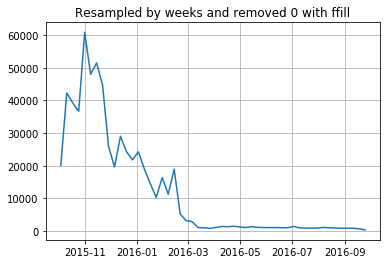

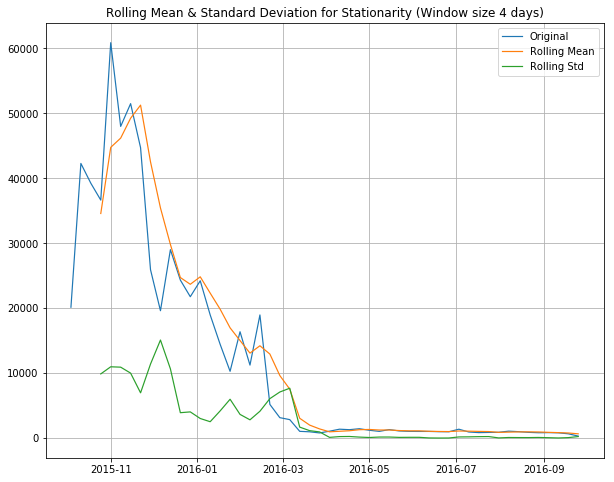

Results of Dickey-Fuller Test:
Test Statistic                 -1.562070
p-value                         0.502614
#Lags Used                      1.000000
Number of Observations Used    50.000000
Critical Value (10%)           -2.598662
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
dtype: float64


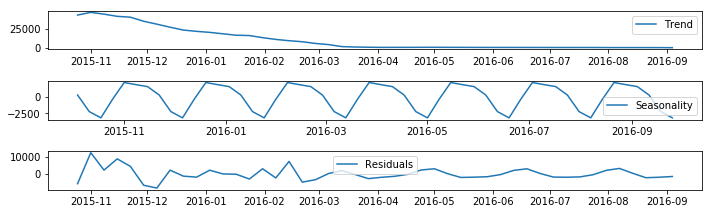

In [125]:
# Resample by weeks
w_df = df.resample("W").sum()
w_df = w_df.reset_index().rename(columns={'Date': 'ds', column_name: 'y'})
w_df = w_df.set_index("ds")
fill_method = "ffill"
w_df['y'] = w_df['y'].replace(to_replace=0, method=fill_method)

#Plot by weeks resample
plt.plot(w_df)
plt.title("Resampled by weeks and removed 0 with %s" % fill_method)
plt.grid()
plt.show()

#Test stationarity for weeks resample
test_stationarity(w_df, win_size=4)

# Show seasonality in weekly resampled time series
(trend, seasonality, resid) = show_seasonality(w_df)

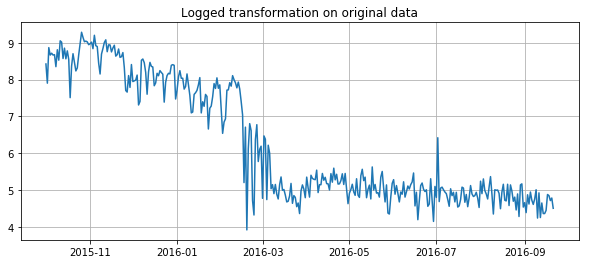

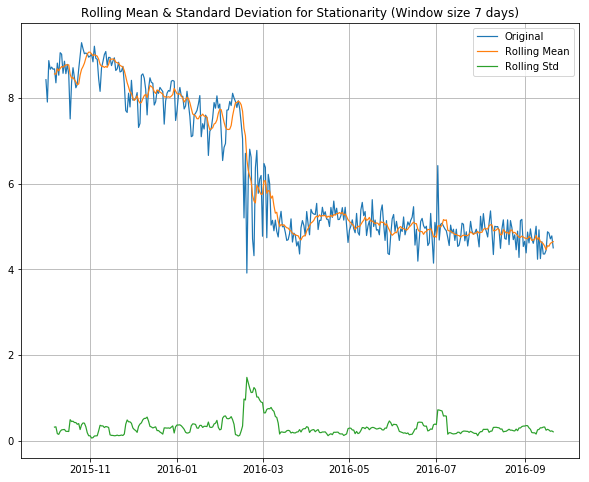

Results of Dickey-Fuller Test:
Test Statistic                  -1.261413
p-value                          0.646636
#Lags Used                       5.000000
Number of Observations Used    351.000000
Critical Value (10%)            -2.571176
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
dtype: float64


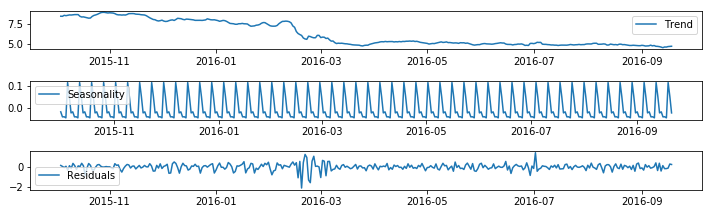

In [126]:
# Transformation to log on original data
l_df = copy.deepcopy(df)
l_df[l_df.columns[0]] = l_df[column_name].replace(to_replace=0, method=fill_method) # Replace 0 in series
l_df[l_df.columns[0]] = np.log(list(l_df[column_name].values))
## l_df[l_df.columns[0]] = np.log(l_df)


#Plot after taking log
plt.figure(figsize=(10,4))
plt.plot(l_df)
plt.title("Logged transformation on original data")
plt.grid()
plt.show()

#Stationarity test on log series
test_stationarity(l_df)

# Show seasonality in original logged time series
(trend, seasonality, resid) = show_seasonality(l_df, freq=7)

In [127]:
shifting = 3

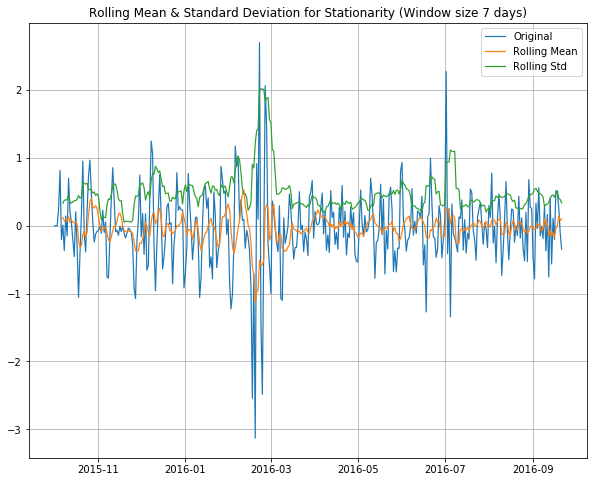

Results of Dickey-Fuller Test:
Test Statistic                -5.655627e+00
p-value                        9.635980e-07
#Lags Used                     1.700000e+01
Number of Observations Used    3.390000e+02
Critical Value (10%)          -2.571332e+00
Critical Value (1%)           -3.449788e+00
Critical Value (5%)           -2.870104e+00
dtype: float64


In [128]:
# Applying differencing with lag shift
l_df_diff = l_df - l_df.shift(shifting)
l_df_diff.fillna(0, inplace=True)

# Stationarity test on log difference
test_stationarity(l_df_diff)

In [77]:
import warnings
warnings.filterwarnings("ignore")
def grid_search(series, search_range=None):
    """Find the best p, d and q values for time series.
    
    :param series: Time series
    :type series: DataFrame
    :param search_range: Maximum value range for p, d and q
    :type search_range: list
    :returns: tuple containing lowest aic and p,d and q combination
    """
    lowest = 100000
    lowest_combination = None
    lowest_mae = 100000
    lowest_r2 = -10
    if search_range is None:
        search_range = range(0, 8)
    p=d=q=search_range
    pdq=list(itertools.product(p, d, q))
    for combination in pdq:
        try:
            model = ARIMA(series, order=combination)
            arima_fit = model.fit()
            prediction = arima_fit.fittedvalues
            if len(series) > len(prediction):
                print(len(series), len(prediction))
                difference = len(series) - len(prediction)
                print("Length difference %s" % difference)
                aseries = series.drop(series.tail(difference).index)
                error = helpers.measure_rmse(aseries, prediction)
                mae = mean_absolute_error(aseries, prediction)
                r2 = r2_score(aseries, prediction)
            else:
                error = helpers.measure_rmse(series, prediction)
                mae = mean_absolute_error(series, prediction)
                r2 = r2_score(series, prediction)
            print("Combination -> %s, error -> %s, mae -> %s, r2 -> %s and aic-> %s" % (combination, error, mae, r2, arima_fit.aic))            
        except Exception as e:
            continue
        if error <= lowest:
            lowest = error
            lowest_combination = combination
            lowest_mae = mae
            lowest_r2 = r2
            aic = arima_fit.aic
    return (lowest_combination, lowest, lowest_mae, lowest_r2)


def grid_search_ma(series, search_range=None):
    """Find the best p, d and q values for time series.
    
    :param series: Time series
    :type series: DataFrame
    :param search_range: Maximum value range for p, d and q
    :type search_range: list
    :returns: tuple containing lowest aic and p,d and q combination
    """
    lowest = 100000
    lowest_combination = None
    lowest_mae = 100000
    lowest_r2 = -10
    if search_range is None:
        search_range = range(0, 12)
    p=d=q=search_range
    pdq=list(itertools.product([0], d, q))
    for combination in pdq:
        try:
            model = ARIMA(series, order=combination)
            arima_fit = model.fit()
            prediction = arima_fit.fittedvalues
            if len(series) > len(prediction):
                print(len(series), len(prediction))
                difference = len(series) - len(prediction)
                print("Length difference %s" % difference)
                aseries = series.drop(series.tail(difference).index)
                error = helpers.measure_rmse(aseries, prediction)
                mae = mean_absolute_error(aseries, prediction)
                r2 = r2_score(aseries, prediction)
            else:
                error = helpers.measure_rmse(series, prediction)
                mae = mean_absolute_error(series, prediction)
                r2 = r2_score(series, prediction)
            print("Combination -> %s, error -> %s, mae -> %s, r2 -> %s and aic-> %s" % (combination, error, mae, r2, arima_fit.aic))            
        except:
            continue
        if error <= lowest:
            lowest = error
            lowest_combination = combination
            lowest_mae = mae
            lowest_r2 = r2
            aic = arima_fit.aic
    return (lowest_combination, lowest, lowest_mae, lowest_r2)

def grid_search_ar(series, search_range=None):
    """Find the best p, d and q values for time series.
    
    :param series: Time series
    :type series: DataFrame
    :param search_range: Maximum value range for p, d and q
    :type search_range: list
    :returns: tuple containing lowest aic and p,d and q combination
    """
    lowest = 100000
    lowest_combination = None
    lowest_mae = 100000
    lowest_r2 = -10
    if search_range is None:
        search_range = range(0, 12)
    p=d=q=search_range
    pdq=list(itertools.product(p, d, [0]))
    for combination in pdq:
        try:
            model = ARIMA(series, order=combination)
            arima_fit = model.fit()
            prediction = arima_fit.fittedvalues
            if len(series) > len(prediction):
                print(len(series), len(prediction))
                difference = len(series) - len(prediction)
                print("Length difference %s" % difference)
                aseries = series.drop(series.tail(difference).index)
                error = helpers.measure_rmse(aseries, prediction)
                mae = mean_absolute_error(aseries, prediction)
                r2 = r2_score(aseries, prediction)
            else:
                error = helpers.measure_rmse(series, prediction)
                mae = mean_absolute_error(series, prediction)
                r2 = r2_score(series, prediction)
            print("Combination -> %s, error -> %s, mae -> %s, r2 -> %s and aic-> %s" % (combination, error, mae, r2, arima_fit.aic))            
        except:
            continue
        if error <= lowest:
            lowest = error
            lowest_combination = combination
            lowest_mae = mae
            lowest_r2 = r2
            aic = arima_fit.aic
    return (lowest_combination, lowest, lowest_mae, lowest_r2)

In [129]:
# df_to_test = copy.deepcopy(l_df_diff)
# df_to_test = copy.deepcopy(df_to_orig)
df_to_test = copy.deepcopy(l_df)
df_to_test.head()
l_df.describe()

,Arrivals to Austria
count,357.000000
mean,6.244368
std,1.628921
min,3.912023
25%,4.890349
50%,5.278115
75%,7.924434
max,9.285819


In [130]:
grid_search_results = grid_search(df_to_test, search_range=range(0, 5))
# grid_search_results = grid_search(df_to_orig)
best_combination = grid_search_results[0]
print("---------")
print("Grid Seach ARIMA result (%s)" % column_name)
print("Final result is: best combination -> %s, error -> %s, mae-> %s r2 -> %s" % grid_search_results)

Combination -> (0, 0, 0), error -> 1.62663763188238, mae -> 1.5174014957282893, r2 -> 1.1102230246251565e-16 and aic-> 1364.493881102634
Combination -> (0, 0, 1), error -> 1.0371665905998035, mae -> 0.9082837091045837, r2 -> 0.5934486507419501 and aic-> 1043.673593910969
Combination -> (0, 0, 2), error -> 0.8198852952716155, mae -> 0.6875111603010888, r2 -> 0.7459468617707841 and aic-> 876.0108896357244
Combination -> (0, 0, 3), error -> 0.7102363017110995, mae -> 0.5742364807177872, r2 -> 0.8093555785101728 and aic-> 773.4354971407781
Combination -> (0, 0, 4), error -> 0.6521636297069808, mae -> 0.5083305714316966, r2 -> 0.8392572035562121 and aic-> 712.8938581846954
357 356
Length difference 1
Combination -> (0, 1, 0), error -> 6.468077015363498, mae -> 6.260288409843334, r2 -> -14.818161347590076 and aic-> 511.1584474675075
357 356
Length difference 1
Combination -> (0, 1, 1), error -> 6.490284822312547, mae -> 6.261089317430391, r2 -> -14.926969494106231 and aic-> 402.4181219222523

In [131]:
# Grid Search Ma
print(column_name)
grid_search_results = grid_search_ma(df_to_test, search_range=range(0, 5))
best_combination_ma = grid_search_results[0]
print("---------")
print("Grid Seach Ma result")
print("Final result is: best combination -> %s, error -> %s, mae-> %s r2 -> %s" % grid_search_results)

Arrivals to Austria
Combination -> (0, 0, 0), error -> 1.62663763188238, mae -> 1.5174014957282893, r2 -> 1.1102230246251565e-16 and aic-> 1364.493881102634
Combination -> (0, 0, 1), error -> 1.0371665905998035, mae -> 0.9082837091045837, r2 -> 0.5934486507419501 and aic-> 1043.673593910969
Combination -> (0, 0, 2), error -> 0.8198852952716155, mae -> 0.6875111603010888, r2 -> 0.7459468617707841 and aic-> 876.0108896357244
Combination -> (0, 0, 3), error -> 0.7102363017110995, mae -> 0.5742364807177872, r2 -> 0.8093555785101728 and aic-> 773.4354971407781
Combination -> (0, 0, 4), error -> 0.6521636297069808, mae -> 0.5083305714316966, r2 -> 0.8392572035562121 and aic-> 712.8938581846954
357 356
Length difference 1
Combination -> (0, 1, 0), error -> 6.468077015363498, mae -> 6.260288409843334, r2 -> -14.818161347590076 and aic-> 511.1584474675075
357 356
Length difference 1
Combination -> (0, 1, 1), error -> 6.490284822312547, mae -> 6.261089317430391, r2 -> -14.926969494106231 and aic

In [132]:
# Grid Search AR
print(column_name)
grid_search_results = grid_search_ar(df_to_test, search_range=range(0, 5))
best_combination_ar = grid_search_results[0]
print("---------")
print("Grid Seach AR result")
print("Final result is: best combination -> %s, error -> %s, mae-> %s r2 -> %s" % grid_search_results)

Arrivals to Austria
Combination -> (0, 0, 0), error -> 1.62663763188238, mae -> 1.5174014957282893, r2 -> 1.1102230246251565e-16 and aic-> 1364.493881102634
357 356
Length difference 1
Combination -> (0, 1, 0), error -> 6.468077015363498, mae -> 6.260288409843334, r2 -> -14.818161347590076 and aic-> 511.1584474675075
357 355
Length difference 2
Combination -> (0, 2, 0), error -> 6.460862407227736, mae -> 6.252726522833232, r2 -> -14.774872456254469 and aic-> 874.3027873270826
Combination -> (1, 0, 0), error -> 0.500023481367203, mae -> 0.33983606993120147, r2 -> 0.9055071020643285 and aic-> 509.31532234996877
357 356
Length difference 1
Combination -> (1, 1, 0), error -> 6.477647209144254, mae -> 6.259721348442942, r2 -> -14.865005212421897 and aic-> 452.9262594114866
357 355
Length difference 2
Combination -> (1, 2, 0), error -> 6.460527090731074, mae -> 6.255336928429883, r2 -> -14.773235078031446 and aic-> 703.8554546882729
Combination -> (2, 0, 0), error -> 0.4643010137302925, mae 

In [133]:
print(column_name)
best_combination

Arrivals to Austria


(3, 0, 4)

Text(0.5, 1.0, 'Plot on series transformation fit, with Root mean squared error: 0.42763811022236436')

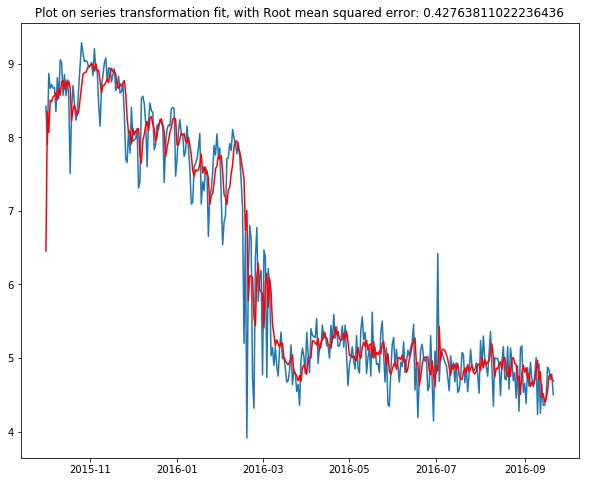

In [134]:
model = ARIMA(df_to_test, order=best_combination)
results_ARIMA = model.fit()

plt.figure(figsize=(10,8))
plt.plot(df_to_test)
plt.plot(results_ARIMA.fittedvalues, color="red")
error = helpers.measure_rmse(df_to_test, results_ARIMA.fittedvalues)
plt.title("Plot on series transformation fit, with Root mean squared error: %s" % error)

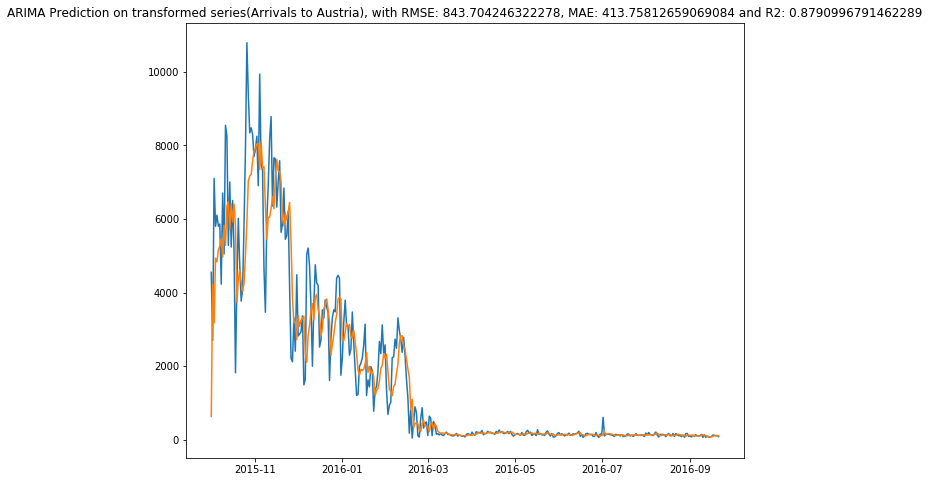

In [135]:
# ARIMA on transformed
# predictions = pd.Series(results_ARIMA.fittedvalues, copy=True).shift(-shifting)
# predictions_cumsum = predictions.cumsum()
# predictions_log = pd.Series(l_df[column_name], index=l_df.index)
# predictions_log = predictions_log.add(predictions, fill_value=0)
# predictions_arima = np.exp(predictions_log)
predictions = pd.Series(results_ARIMA.fittedvalues, copy=True) # Delete Later
predictions_arima = np.exp(predictions) # Delete later
plt.figure(figsize=(10,8))
plt.plot(df)
plt.plot(predictions_arima)
error = helpers.measure_rmse(df, predictions_arima)
mae = mean_absolute_error(df, predictions_arima) 
r2 = r2_score(df, predictions_arima)
plt.title("ARIMA Prediction on transformed series(%s), with RMSE: %s, MAE: %s and R2: %s" % (column_name, error, mae, r2))
plt.show()

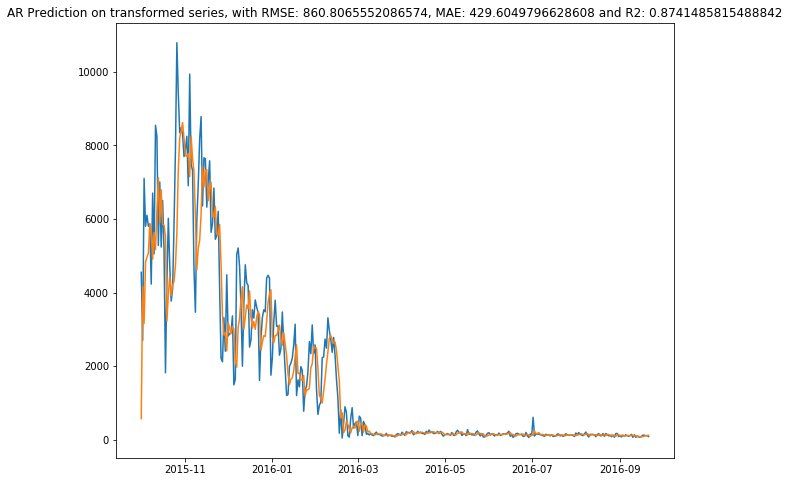

In [136]:
# AR on transformed
model = ARIMA(df_to_test, order=(best_combination_ar[0], best_combination_ar[1], 0))
results_ARIMA = model.fit()
# predictions = pd.Series(results_ARIMA.fittedvalues, copy=True).shift(-shifting)
# predictions_cumsum = predictions.cumsum()
# predictions_log = pd.Series(l_df[column_name], index=l_df.index)
# predictions_log = predictions_log.add(predictions, fill_value=0)
# predictions_arima = np.exp(predictions_log)
predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_arima = np.exp(predictions)
plt.figure(figsize=(10,8))
plt.plot(df)
plt.plot(predictions_arima)
error = helpers.measure_rmse(df, predictions_arima)
mae = mean_absolute_error(df, predictions_arima) 
r2 = r2_score(df, predictions_arima)
plt.title("AR Prediction on transformed series, with RMSE: %s, MAE: %s and R2: %s" % (error, mae, r2))
plt.show()

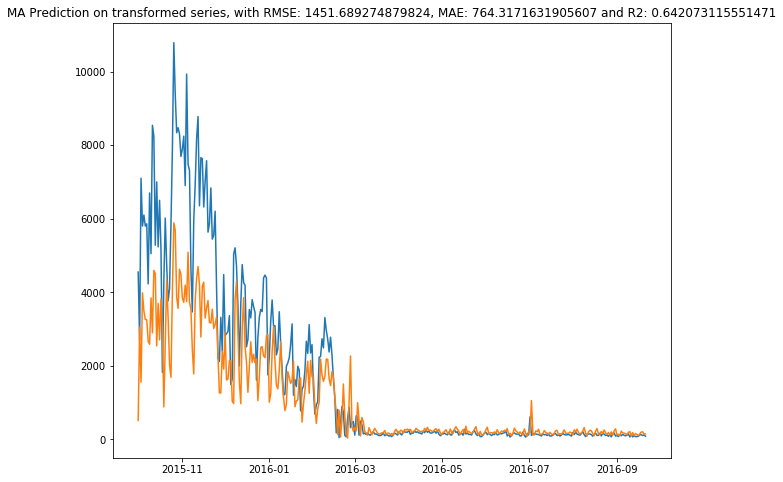

In [137]:
# MA on transformed
model = ARIMA(df_to_test, order=(0, best_combination_ma[1], best_combination_ma[2]))
results_ARIMA = model.fit()
# predictions = pd.Series(results_ARIMA.fittedvalues, copy=True).shift(-shifting)
# predictions_cumsum = predictions.cumsum()
# predictions_log = pd.Series(l_df[column_name], index=l_df.index)
# predictions_log = predictions_log.add(predictions, fill_value=0)
# predictions_arima = np.exp(predictions_log)
predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_arima = np.exp(predictions)
plt.figure(figsize=(10,8))
plt.plot(df)
plt.plot(predictions_arima)
error = helpers.measure_rmse(df, predictions_arima)
mae = mean_absolute_error(df, predictions_arima) 
r2 = r2_score(df, predictions_arima)
plt.title("MA Prediction on transformed series, with RMSE: %s, MAE: %s and R2: %s" % (error, mae, r2))
plt.show()

In [138]:
orig_df = df_to_orig

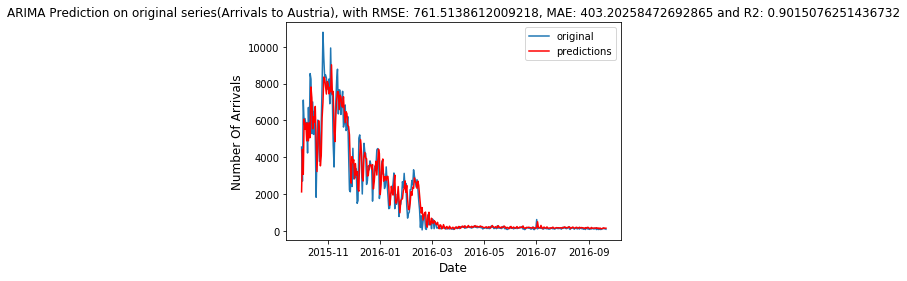

In [139]:
# ARIMA on original
model = ARIMA(orig_df, order=best_combination) 
results_ARIMA = model.fit() # If fit doest not work apply grid search on df_to_orig to find hyperparameters

plt.figure(figsize=(6,4))
plt.plot(orig_df, label="original")
plt.plot(results_ARIMA.fittedvalues, color="red", label="predictions")
error = helpers.measure_rmse(orig_df, results_ARIMA.fittedvalues)
mae = mean_absolute_error(orig_df, results_ARIMA.fittedvalues) 
r2 = r2_score(orig_df, results_ARIMA.fittedvalues)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.title("ARIMA Prediction on original series(%s), with RMSE: %s, MAE: %s and R2: %s" % (column_name, error, mae, r2))
plt.legend(loc='best')
plt.show()

In [616]:
#ARIMA Forecasting for original data
results_ARIMA.predict("2016-09-17", "2016-09-29")

2016-09-17    -10.950168
2016-09-18     45.665353
2016-09-19     87.899473
2016-09-20     93.410825
2016-09-21     93.246990
2016-09-22     42.394670
2016-09-23     12.790800
2016-09-24     -5.370817
2016-09-25      0.926621
2016-09-26     39.812333
2016-09-27     87.913301
2016-09-28    117.490860
2016-09-29    138.419716
Freq: D, dtype: float64

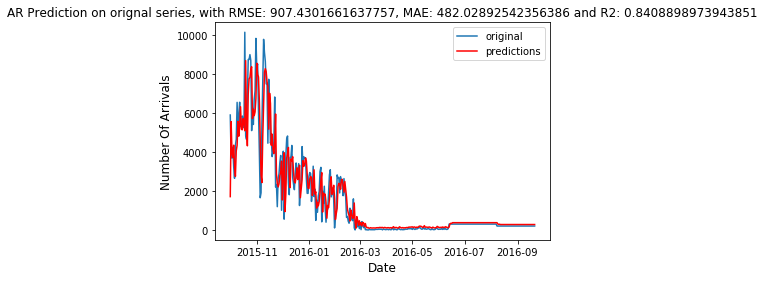

In [287]:
# AR Model
model = ARIMA(orig_df, order=(best_combination_ar[0], best_combination_ar[1], 0))
results_ARIMA = model.fit()

plt.figure(figsize=(6,4))
plt.plot(orig_df, label="original")
plt.plot(results_ARIMA.fittedvalues, color="red", label="predictions")
error = helpers.measure_rmse(orig_df, results_ARIMA.fittedvalues)
mae = mean_absolute_error(orig_df, results_ARIMA.fittedvalues) 
r2 = r2_score(orig_df, results_ARIMA.fittedvalues)  
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.title("AR Prediction on orignal series, with RMSE: %s, MAE: %s and R2: %s" % (error, mae, r2))
plt.legend(loc='best')
plt.show()

In [151]:
#AR Forecasting
results_ARIMA.predict("2016-09-17", "2016-09-29")

2016-09-17    114.106450
2016-09-18    253.075918
2016-09-19    266.981164
2016-09-20    180.488171
2016-09-21    214.334986
2016-09-22    220.673175
2016-09-23    302.398973
2016-09-24    351.835923
2016-09-25    391.937719
2016-09-26    442.953172
2016-09-27    497.254061
2016-09-28    546.665598
2016-09-29    590.832350
Freq: D, dtype: float64

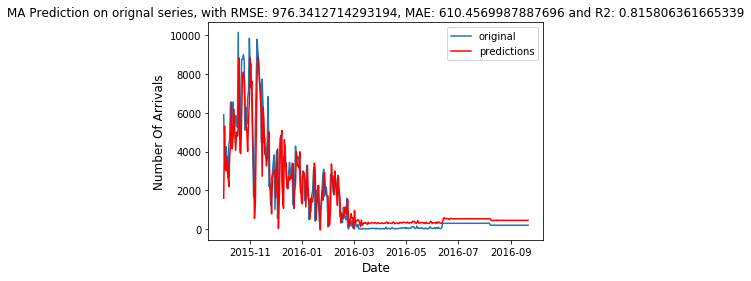

In [288]:
# MA Model

model = ARIMA(orig_df, order=(0, best_combination_ma[1], best_combination_ma[2]))
results_ARIMA = model.fit()

plt.figure(figsize=(6,4))
plt.plot(orig_df, label="original")
plt.plot(results_ARIMA.fittedvalues, color="red", label="predictions")
error = helpers.measure_rmse(orig_df, results_ARIMA.fittedvalues)
mae = mean_absolute_error(orig_df, results_ARIMA.fittedvalues) 
r2 = r2_score(orig_df, results_ARIMA.fittedvalues)  
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.title("MA Prediction on orignal series, with RMSE: %s, MAE: %s and R2: %s" % (error, mae, r2))
plt.legend(loc='best')
plt.show()

In [112]:
#MA Forecasting
results_ARIMA.predict("2016-09-17", "2016-09-29")

2016-09-17    471.923662
2016-09-18    558.294187
2016-09-19    372.781991
2016-09-20    398.517232
2016-09-21    234.997876
2016-09-22    276.830695
2016-09-23    404.135885
2016-09-24    493.348693
2016-09-25    559.965868
2016-09-26    592.675583
2016-09-27    592.675583
2016-09-28    592.675583
2016-09-29    592.675583
Freq: D, dtype: float64

In [150]:
def fit_and_plot_cv(train, test, combination, log_scale=True):
    test_len = len(test)
    model = ARIMA(train, order=combination)
    fitted = model.fit(disp=-1)  

    # Forecast
    fc, se, conf = fitted.forecast(test_len, alpha=0.10)  # 95% conf
    
    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    if log_scale:
        lower_series = pd.Series(np.exp(conf[:, 0]), index=test.index)
        upper_series = pd.Series(np.exp(conf[:, 1]), index=test.index)
        train = np.exp(train)
        test = np.exp(test)
        fc_series = np.exp(fc_series)
    else:
        lower_series = pd.Series(conf[:, 0], index=test.index)
        upper_series = pd.Series(conf[:, 1], index=test.index)
    
    # Plot
    plt.figure(figsize=(7,4), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    

Iteration (1)


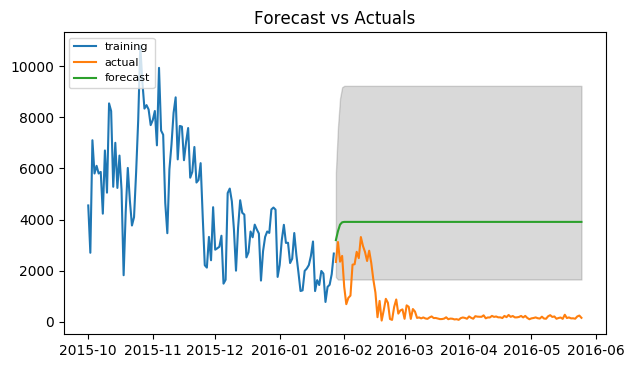

Iteration (2)


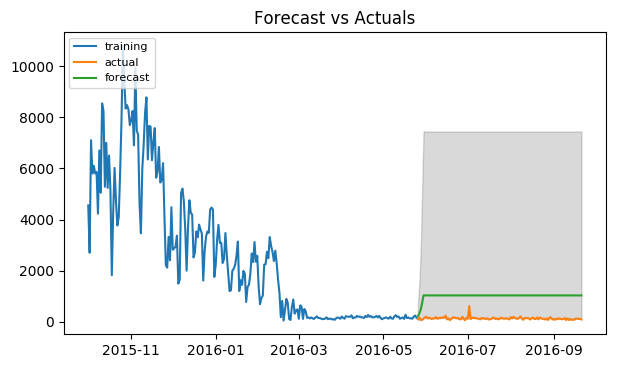

In [153]:
# Cross Validation
df_to_cv = df_to_test
s = TimeSeriesSplit(n_splits=2).split(df_to_cv)
itr = 0
for train_index, test_index in s:
    itr = itr + 1
    print("Iteration (%s)" % itr)
    train = df_to_cv.ix[train_index]
    test = df_to_cv.ix[test_index]
    fit_and_plot_cv(train, test, best_combination_ma)
    

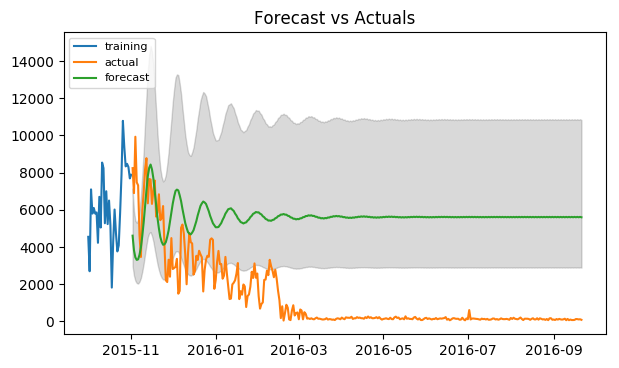

In [154]:
# Test split by given percentage
percent = 0.09
split_range = int(len(df_to_test) * percent)
train = df_to_test[0:split_range]
test = df_to_test[split_range:]
fit_and_plot_cv(train, test, best_combination)
